In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import transformers
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys

import keras
import tensorflow as tf

from transformers import BertModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from ast import literal_eval

In [3]:
df_prompts = pd.read_csv('prompts_train.csv')
df_summaries = pd.read_csv('summaries_train.csv')

In [4]:
df_prompts

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [5]:
df_summaries

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128


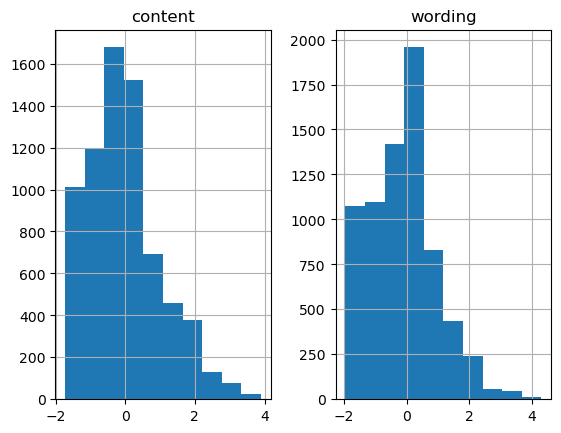

In [6]:
df_summaries.hist();

In [8]:
df_prompts['prompt_question'].apply(lambda s : len(s))

0     77
1    184
2    105
3    104
Name: prompt_question, dtype: int64

In [9]:
result = df_prompts['prompt_question'].apply(lambda s : len(s))

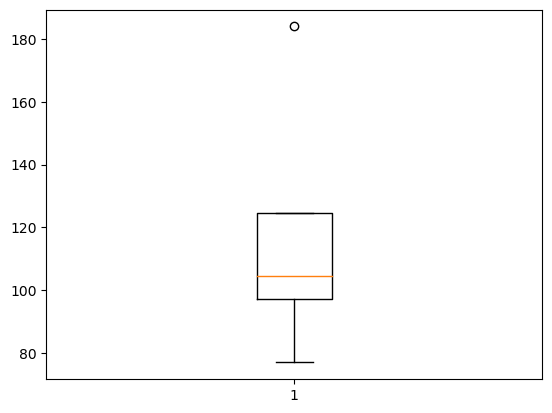

In [10]:
plt.boxplot(result)
plt.show()

In [12]:
df_prompts['prompt_question'].apply(lambda s : len(s.split()))

0    13
1    27
2    19
3    18
Name: prompt_question, dtype: int64

In [13]:
result = df_prompts['prompt_question'].apply(lambda s : len(s.split()))

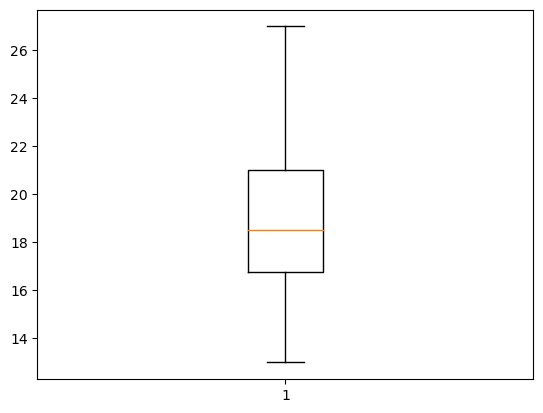

In [14]:
plt.boxplot(result)
plt.show()

In [16]:
result = df_prompts['prompt_title'].apply(lambda s : len(s))


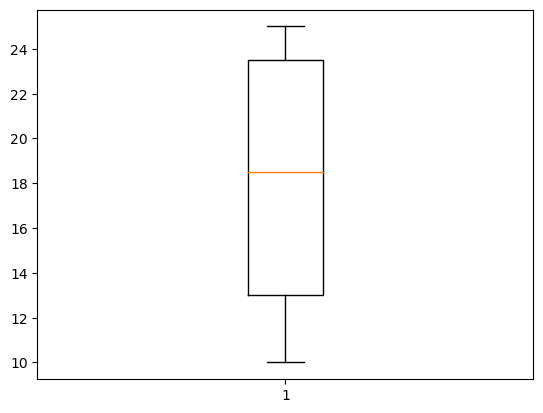

In [17]:
plt.boxplot(result)
plt.show()

In [19]:
result = df_prompts['prompt_title'].apply(lambda s : len(s.split()))

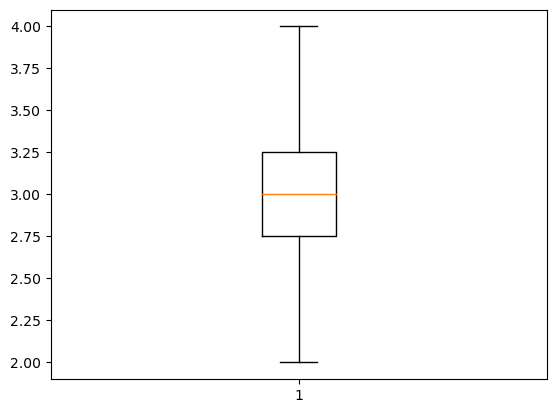

In [20]:
plt.boxplot(result)
plt.show()

In [22]:
result = df_prompts['prompt_text'].apply(lambda s : len(s))

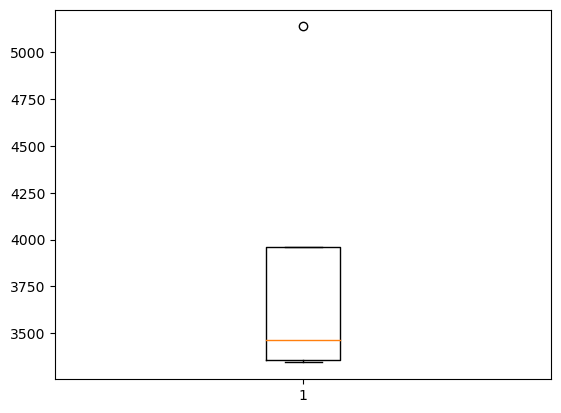

In [23]:
plt.boxplot(result)
plt.show()

In [25]:
result = df_prompts['prompt_text'].apply(lambda s : len(s.split()))

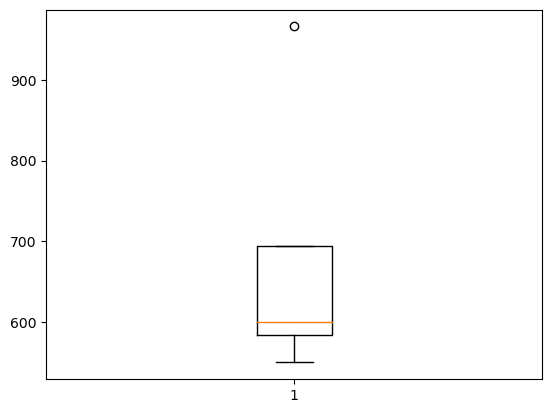

In [26]:
plt.boxplot(result)
plt.show()

In [28]:
df_summaries.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [30]:
result = df_summaries['text'].apply(lambda s : len(s.split()))

In [31]:
result

0        61
1        52
2       235
3        25
4       203
       ... 
7160     66
7161     42
7162     48
7163     59
7164    105
Name: text, Length: 7165, dtype: int64

In [32]:
result.describe()

count    7165.000000
mean       74.811724
std        53.503992
min        22.000000
25%        39.000000
50%        58.000000
75%        92.000000
max       647.000000
Name: text, dtype: float64

<Axes: >

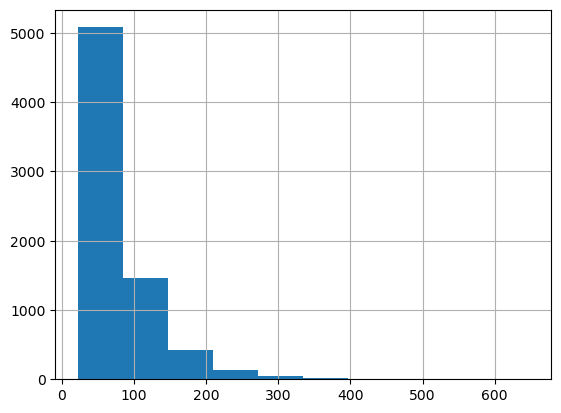

In [33]:
result.hist()

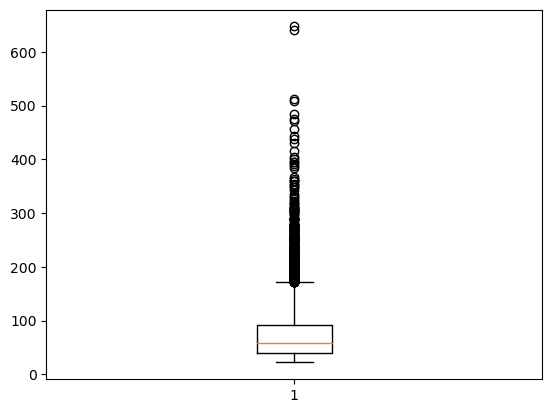

In [34]:
plt.boxplot(result)
plt.show()

In [36]:
result = df_summaries['text'].apply(lambda s : len(s))

In [37]:
result.describe()

count    7165.000000
mean      418.776971
std       307.833685
min       114.000000
25%       216.000000
50%       320.000000
75%       513.000000
max      3940.000000
Name: text, dtype: float64

<Axes: >

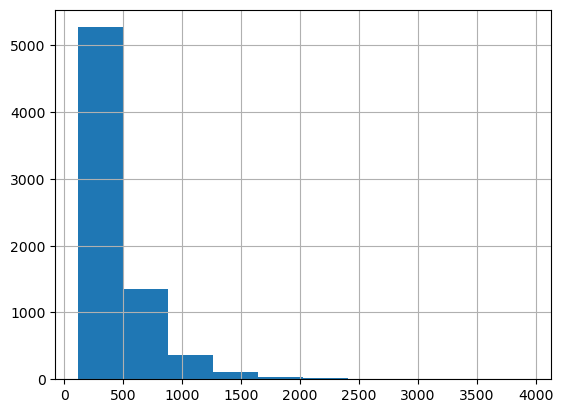

In [38]:
result.hist()

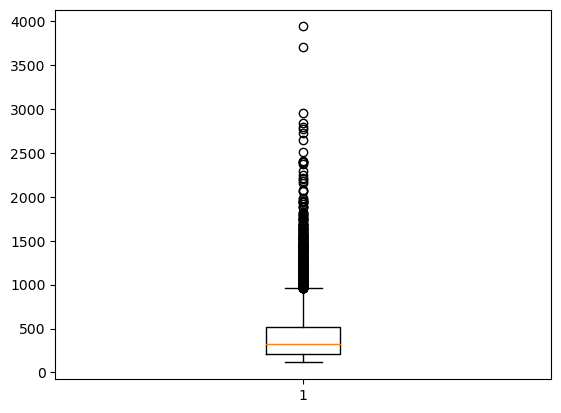

In [39]:
plt.boxplot(result)
plt.show()

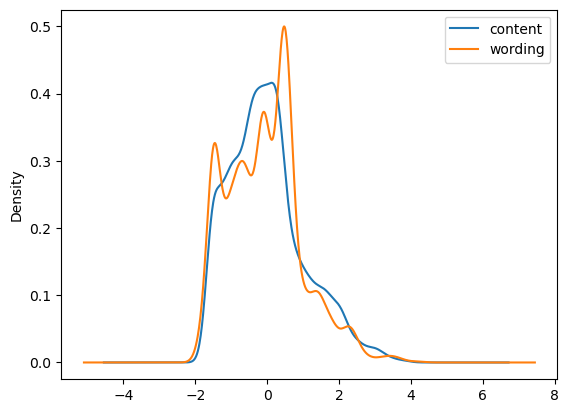

In [41]:

kde = pd.DataFrame({
    'content': df_summaries['content'], 
    'wording': df_summaries['wording']
})

ax = kde.plot.kde()


In [42]:


def full_text_embedding(
    sentences: str,
    model,
    tokenizer,
    window_length: int = 510,
    device="cpu",
    tensor_out: bool = False,
    safe_mode: bool = True):
    
    
    
    tokenizer.model_max_length = sys.maxsize
    encoded_input = tokenizer(
    sentences,
    padding=False,
    truncation=False,
    add_special_tokens=False,
    return_tensors="pt")


    pad_token = torch.tensor(tokenizer.vocab["[PAD]"], dtype=torch.long).view((1, -1))
    cls_token = torch.tensor(tokenizer.vocab["[CLS]"], dtype=torch.long).view((1, -1))
    sep_token = torch.tensor(tokenizer.vocab["[SEP]"], dtype=torch.long).view((1, -1))
    att_one = torch.tensor(1, dtype=torch.int).view((1, -1))

    input_ids_all = encoded_input["input_ids"]
    input_ids_len = input_ids_all.size(dim=1)

    attention_mask_all = encoded_input["attention_mask"]
    no_of_chunks = input_ids_len // window_length + 1
    input_ids = []
    attention_mask = []

    for i in range(no_of_chunks):
        input_ids_chunk = input_ids_all[
            :, i * window_length : i * window_length + window_length
        ]
        attention_mask_chunk = attention_mask_all[
            :, i * window_length : i * window_length + window_length
        ]

        input_ids_chunk = torch.cat([cls_token, input_ids_chunk, sep_token], dim=1)
        attention_mask_chunk = torch.cat(
            [att_one, attention_mask_chunk, att_one], dim=1
        )
        if (input_ids_chunk.size(dim=1) < window_length + 2) and no_of_chunks > 1:
            n_pads = window_length + 2 - input_ids_chunk.size(dim=1)
            pad_tokens = pad_token.repeat((1, n_pads))
            input_ids_chunk = torch.cat([input_ids_chunk, pad_tokens], dim=1)
            attention_mask_chunk = torch.cat(
                [
                    attention_mask_chunk,
                    torch.zeros(n_pads, dtype=torch.int).view(1, -1),
                ],
                dim=1,
            )
        input_ids.append(input_ids_chunk)
        attention_mask.append(attention_mask_chunk)
    input_dict = {
        "input_ids": torch.cat(input_ids, dim=0),
        "attention_mask": torch.cat(attention_mask, dim=0),
    }
    model.eval()
    
    input_dict = {k: v.to(device) for k, v in input_dict.items()}
    model = model.to(device)
    with torch.no_grad():
        model_output = model(**input_dict).pooler_output.mean(dim=0).to(device)
            
    embeddings = torch.nn.functional.normalize(model_output, dim=0)
    if tensor_out:
        return embeddings
    return embeddings.cpu().numpy()

In [43]:
def simple_embedding(
    sentences,
    model,
    tokenizer,
    max_length: int = 512,
    device="cpu",
    tensor_out: bool = False,
    safe_mode: bool = True):

    encoded_input = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
        return_tensors="pt")
    
    model.eval()
    
    
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model = model.to(device)
    with torch.no_grad():
        model_output = model(**encoded_input).pooler_output.to(device)
        
    embeddings = torch.nn.functional.normalize(model_output)[0]
    if tensor_out:
        return embeddings
    return embeddings.cpu().numpy()

In [44]:
device = torch.device('cuda')
device

device(type='cuda')

In [45]:
tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
model = BertModel.from_pretrained("setu4993/LaBSE")

In [46]:
df_prompts['title_emb'] = df_prompts['prompt_title'].apply(lambda   x: simple_embedding(x, model, tokenizer, device = device))

In [47]:
df_prompts

,prompt_id,prompt_question,prompt_title,prompt_text,title_emb
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"[-0.08932492, -0.068411075, -0.016106218, -0.0..."
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"[0.00022895275, -0.039324638, -0.0043196497, -..."
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"[0.016256578, -0.0031303794, 5.558536e-05, 0.0..."
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","[-0.018398214, -0.020214139, 0.013971804, -0.0..."


In [48]:
df_prompts['question_emb'] = df_prompts['prompt_question'].apply(lambda   x: simple_embedding(x, model, tokenizer, device = device))

In [49]:
df_prompts

,prompt_id,prompt_question,prompt_title,prompt_text,title_emb,question_emb
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"[-0.08932492, -0.068411075, -0.016106218, -0.0...","[-0.031959318, -0.033907507, -0.00889089, 0.00..."
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02..."
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"[0.016256578, -0.0031303794, 5.558536e-05, 0.0...","[-0.034599487, -0.025179274, 0.03280769, 0.027..."
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","[-0.018398214, -0.020214139, 0.013971804, -0.0...","[-0.033672567, 0.012198868, 0.03810364, 0.0155..."


In [50]:
df_summaries

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128


In [51]:
df_prompts['prompt_text_emb'] = df_prompts['prompt_text'].apply(lambda   x: full_text_embedding(x, model, tokenizer, device = device))

In [52]:
df_prompts

,prompt_id,prompt_question,prompt_title,prompt_text,title_emb,question_emb,prompt_text_emb
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"[-0.08932492, -0.068411075, -0.016106218, -0.0...","[-0.031959318, -0.033907507, -0.00889089, 0.00...","[-0.04306613, -0.023110958, -0.02706158, -0.02..."
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02...","[-0.02251732, 0.0016785765, -0.025379421, -0.0..."
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"[0.016256578, -0.0031303794, 5.558536e-05, 0.0...","[-0.034599487, -0.025179274, 0.03280769, 0.027...","[-0.03517206, -0.022900006, 0.026386924, -0.02..."
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","[-0.018398214, -0.020214139, 0.013971804, -0.0...","[-0.033672567, 0.012198868, 0.03810364, 0.0155...","[-0.017805072, -0.025734227, 0.012488186, -0.0..."


In [53]:
df_summaries['text_emb'] = df_summaries['text'].apply(lambda   x: full_text_embedding(x, model, tokenizer, device = device))

In [54]:
df_summaries

,student_id,prompt_id,text,content,wording,text_emb
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,"[-0.00889965, 0.031088736, 0.05817128, -0.0096..."
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,"[-0.025216013, -0.019743314, -0.04259252, -0.0..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"[-0.018083498, -0.018888656, 0.008433141, -0.0..."
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"[-0.0060328417, 0.049174283, -0.05335051, 0.00..."
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,"[-0.013733417, -0.0051567475, 0.0022239285, 0...."
...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,"[-0.03741912, -0.002362705, -0.041734356, -0.0..."
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,"[-0.0014121552, 0.061955474, -0.024663912, -0...."
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,"[0.0006731156, 0.01593317, -0.004639309, -0.03..."
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,"[-0.037159644, -0.028239468, -0.007201393, 0.0..."


In [55]:
df_prompts = df_prompts.drop(['prompt_question', 'prompt_title', 'prompt_text'], axis = 1)

In [56]:
df_prompts

,prompt_id,title_emb,question_emb,prompt_text_emb
0,39c16e,"[-0.08932492, -0.068411075, -0.016106218, -0.0...","[-0.031959318, -0.033907507, -0.00889089, 0.00...","[-0.04306613, -0.023110958, -0.02706158, -0.02..."
1,3b9047,"[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02...","[-0.02251732, 0.0016785765, -0.025379421, -0.0..."
2,814d6b,"[0.016256578, -0.0031303794, 5.558536e-05, 0.0...","[-0.034599487, -0.025179274, 0.03280769, 0.027...","[-0.03517206, -0.022900006, 0.026386924, -0.02..."
3,ebad26,"[-0.018398214, -0.020214139, 0.013971804, -0.0...","[-0.033672567, 0.012198868, 0.03810364, 0.0155...","[-0.017805072, -0.025734227, 0.012488186, -0.0..."


In [57]:
df_summaries = df_summaries.drop(['student_id', 'text'], axis = 1)

In [58]:
df_summaries

,prompt_id,content,wording,text_emb
0,814d6b,0.205683,0.380538,"[-0.00889965, 0.031088736, 0.05817128, -0.0096..."
1,ebad26,-0.548304,0.506755,"[-0.025216013, -0.019743314, -0.04259252, -0.0..."
2,3b9047,3.128928,4.231226,"[-0.018083498, -0.018888656, 0.008433141, -0.0..."
3,3b9047,-0.210614,-0.471415,"[-0.0060328417, 0.049174283, -0.05335051, 0.00..."
4,814d6b,3.272894,3.219757,"[-0.013733417, -0.0051567475, 0.0022239285, 0...."
...,...,...,...,...
7160,ebad26,0.205683,0.380538,"[-0.03741912, -0.002362705, -0.041734356, -0.0..."
7161,3b9047,-0.308448,0.048171,"[-0.0014121552, 0.061955474, -0.024663912, -0...."
7162,3b9047,-1.408180,-0.493603,"[0.0006731156, 0.01593317, -0.004639309, -0.03..."
7163,39c16e,-0.393310,0.627128,"[-0.037159644, -0.028239468, -0.007201393, 0.0..."


In [59]:
df_summaries = df_summaries.merge(df_prompts, how= 'left', on = 'prompt_id')

In [60]:
df_summaries.to_pickle('df_summaries_emb.pickle')

In [61]:
df = pd.read_pickle('df_summaries_emb.pickle')

In [62]:
df_summaries

,prompt_id,content,wording,text_emb,title_emb,question_emb,prompt_text_emb
0,814d6b,0.205683,0.380538,"[-0.00889965, 0.031088736, 0.05817128, -0.0096...","[0.016256578, -0.0031303794, 5.558536e-05, 0.0...","[-0.034599487, -0.025179274, 0.03280769, 0.027...","[-0.03517206, -0.022900006, 0.026386924, -0.02..."
1,ebad26,-0.548304,0.506755,"[-0.025216013, -0.019743314, -0.04259252, -0.0...","[-0.018398214, -0.020214139, 0.013971804, -0.0...","[-0.033672567, 0.012198868, 0.03810364, 0.0155...","[-0.017805072, -0.025734227, 0.012488186, -0.0..."
2,3b9047,3.128928,4.231226,"[-0.018083498, -0.018888656, 0.008433141, -0.0...","[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02...","[-0.02251732, 0.0016785765, -0.025379421, -0.0..."
3,3b9047,-0.210614,-0.471415,"[-0.0060328417, 0.049174283, -0.05335051, 0.00...","[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02...","[-0.02251732, 0.0016785765, -0.025379421, -0.0..."
4,814d6b,3.272894,3.219757,"[-0.013733417, -0.0051567475, 0.0022239285, 0....","[0.016256578, -0.0031303794, 5.558536e-05, 0.0...","[-0.034599487, -0.025179274, 0.03280769, 0.027...","[-0.03517206, -0.022900006, 0.026386924, -0.02..."
...,...,...,...,...,...,...,...
7160,ebad26,0.205683,0.380538,"[-0.03741912, -0.002362705, -0.041734356, -0.0...","[-0.018398214, -0.020214139, 0.013971804, -0.0...","[-0.033672567, 0.012198868, 0.03810364, 0.0155...","[-0.017805072, -0.025734227, 0.012488186, -0.0..."
7161,3b9047,-0.308448,0.048171,"[-0.0014121552, 0.061955474, -0.024663912, -0....","[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02...","[-0.02251732, 0.0016785765, -0.025379421, -0.0..."
7162,3b9047,-1.408180,-0.493603,"[0.0006731156, 0.01593317, -0.004639309, -0.03...","[0.00022895275, -0.039324638, -0.0043196497, -...","[-0.047027264, -0.012345067, 0.06242449, -0.02...","[-0.02251732, 0.0016785765, -0.025379421, -0.0..."
7163,39c16e,-0.393310,0.627128,"[-0.037159644, -0.028239468, -0.007201393, 0.0...","[-0.08932492, -0.068411075, -0.016106218, -0.0...","[-0.031959318, -0.033907507, -0.00889089, 0.00...","[-0.04306613, -0.023110958, -0.02706158, -0.02..."


In [63]:
def converter(s):
    s = s[1:-1]
    l = s.split()
    l = [float(x) for x in l if x != ""]
    
    return l 

In [64]:
df = pd.read_csv('df_summaries_emb.csv', converters={'text_emb': converter, 'title_emb': converter, 'question_emb': converter, 'prompt_text_emb': converter })

In [65]:
df.head()

,Unnamed: 0,prompt_id,content,wording,text_emb,title_emb,question_emb,prompt_text_emb
0,0,814d6b,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."
1,1,ebad26,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -...","[-0.0183982141, -0.0202141386, 0.0139718037, -...","[-0.0336725675, 0.0121988682, 0.0381036401, 0....","[-0.0178050715, -0.0257342272, 0.0124881864, -..."
2,2,3b9047,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
3,3,3b9047,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
4,4,814d6b,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."


In [66]:
df1 = df.copy()

In [67]:
df1

,Unnamed: 0,prompt_id,content,wording,text_emb,title_emb,question_emb,prompt_text_emb
0,0,814d6b,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."
1,1,ebad26,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -...","[-0.0183982141, -0.0202141386, 0.0139718037, -...","[-0.0336725675, 0.0121988682, 0.0381036401, 0....","[-0.0178050715, -0.0257342272, 0.0124881864, -..."
2,2,3b9047,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
3,3,3b9047,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
4,4,814d6b,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."
...,...,...,...,...,...,...,...,...
7160,7160,ebad26,0.205683,0.380538,"[-0.0374191217, -0.00236270507, -0.0417343564,...","[-0.0183982141, -0.0202141386, 0.0139718037, -...","[-0.0336725675, 0.0121988682, 0.0381036401, 0....","[-0.0178050715, -0.0257342272, 0.0124881864, -..."
7161,7161,3b9047,-0.308448,0.048171,"[-0.00141215522, 0.0619554743, -0.0246639121, ...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
7162,7162,3b9047,-1.408180,-0.493603,"[0.000673115603, 0.0159331709, -0.0046393089, ...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
7163,7163,39c16e,-0.393310,0.627128,"[-0.0371596441, -0.0282394681, -0.00720139313,...","[-0.0893249214, -0.0684110746, -0.0161062181, ...","[-0.03195932, -0.03390751, -0.00889089, 0.0033...","[-0.0430661291, -0.0231109578, -0.0270615797, ..."


In [68]:
df = df.drop(['Unnamed: 0', 'prompt_id'], axis= 1)

In [69]:
df.head()

,content,wording,text_emb,title_emb,question_emb,prompt_text_emb
0,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."
1,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -...","[-0.0183982141, -0.0202141386, 0.0139718037, -...","[-0.0336725675, 0.0121988682, 0.0381036401, 0....","[-0.0178050715, -0.0257342272, 0.0124881864, -..."
2,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
3,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
4,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   content          7165 non-null   float64
 1   wording          7165 non-null   float64
 2   text_emb         7165 non-null   object 
 3   title_emb        7165 non-null   object 
 4   question_emb     7165 non-null   object 
 5   prompt_text_emb  7165 non-null   object 
dtypes: float64(2), object(4)
memory usage: 336.0+ KB


In [71]:
train, test = train_test_split(df, test_size=0.1, random_state= 1234)

In [72]:
test

,content,wording,text_emb,title_emb,question_emb,prompt_text_emb
4737,-1.264214,-1.505073,"[-0.00294066966, 0.0241311677, 0.0504101217, 0...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
1058,-0.093814,0.503833,"[-0.0244439989, 0.00058023294, 0.0192502365, 0...","[-0.0893249214, -0.0684110746, -0.0161062181, ...","[-0.03195932, -0.03390751, -0.00889089, 0.0033...","[-0.0430661291, -0.0231109578, -0.0270615797, ..."
1816,-0.393310,0.627128,"[-0.05552609, 0.0219813, -0.01827106, -0.02478...","[-0.0893249214, -0.0684110746, -0.0161062181, ...","[-0.03195932, -0.03390751, -0.00889089, 0.0033...","[-0.0430661291, -0.0231109578, -0.0270615797, ..."
4008,0.205683,0.380538,"[-0.0323318541, -0.0263510868, -0.0180624332, ...","[-0.0893249214, -0.0684110746, -0.0161062181, ...","[-0.03195932, -0.03390751, -0.00889089, 0.0033...","[-0.0430661291, -0.0231109578, -0.0270615797, ..."
7019,0.205683,0.380538,"[-0.0344237126, 0.0229314882, -0.011390687, -0...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
...,...,...,...,...,...,...
5787,0.233385,-0.838378,"[-0.0298999585, 0.0328755751, -0.0180055238, -...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
3769,-1.012973,-0.664340,"[-0.0141265662, 0.0533791482, 0.00733632362, -...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
7140,-0.349061,-0.671255,"[0.00481781596, -0.0397982039, -0.0103995083, ...","[-0.0183982141, -0.0202141386, 0.0139718037, -...","[-0.0336725675, 0.0121988682, 0.0381036401, 0....","[-0.0178050715, -0.0257342272, 0.0124881864, -..."
5723,-1.236282,-0.285223,"[-0.07042486, -0.00104277, -0.04444584, -0.056...","[-0.0893249214, -0.0684110746, -0.0161062181, ...","[-0.03195932, -0.03390751, -0.00889089, 0.0033...","[-0.0430661291, -0.0231109578, -0.0270615797, ..."


In [73]:
train_y_1 = train['content']
train_y_2 = train['wording']


In [74]:
train_X_1 = train['text_emb'].apply(lambda x: pd.Series(x))
train_X_1

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
3423,-0.043827,-0.015886,0.004615,0.014486,0.004058,-0.041484,-0.017152,-0.038751,0.014196,-0.021871,...,-0.001181,-0.030090,-0.044825,0.005554,-0.042248,-0.037979,-0.018324,0.002993,0.017103,0.025709
1170,-0.017125,-0.015602,-0.032616,-0.051328,-0.030091,-0.030994,-0.025522,0.011146,0.017378,-0.048528,...,0.042231,-0.028010,-0.017540,0.059310,-0.013325,-0.019339,-0.058937,0.060871,0.011120,-0.065351
2008,-0.014917,-0.018772,0.021551,0.034327,-0.014503,-0.056546,-0.046836,0.028907,-0.015141,-0.056596,...,-0.046123,-0.065184,-0.051782,-0.055797,0.015110,-0.060309,-0.003206,0.037168,0.017986,-0.039410
1939,0.037519,-0.055412,-0.003938,0.020427,0.002057,-0.036864,-0.038880,0.032788,0.025791,0.047194,...,-0.074472,0.045443,-0.059753,0.045542,-0.049156,0.015406,-0.011177,0.028790,0.040886,-0.061834
1610,-0.024815,-0.018166,-0.003109,-0.013737,-0.028663,0.018625,-0.034284,-0.028818,0.026580,0.029592,...,-0.025908,0.038128,0.036111,0.053707,0.023566,-0.066609,0.004431,0.033226,-0.021119,-0.035625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,-0.021124,0.002251,0.010162,-0.011928,-0.021747,0.012686,-0.036749,0.031119,0.021197,-0.001887,...,-0.038470,0.012418,-0.011576,0.062901,0.002275,-0.054348,0.028152,0.026319,-0.001931,-0.014155
3276,-0.037252,0.028854,-0.021733,0.014196,-0.059290,-0.029997,-0.003647,0.000463,0.028219,-0.022263,...,-0.057547,0.066015,-0.027146,0.038116,0.020722,-0.075737,0.038993,0.049041,-0.009397,-0.008438
1318,-0.018984,0.029994,-0.014614,-0.032303,-0.016004,0.032427,-0.051858,-0.019800,0.007637,-0.026076,...,-0.015698,0.025173,0.021302,0.069523,0.051732,-0.058295,-0.020368,0.029842,-0.022298,-0.053367
723,-0.055575,0.012053,-0.016333,-0.004461,0.042268,-0.049656,-0.059516,-0.007636,0.014838,-0.024824,...,-0.067605,-0.019741,-0.072913,0.042168,0.000295,-0.011273,0.030409,0.037162,0.001919,-0.033952


In [75]:
train_X_2 = train['title_emb'].apply(lambda x: pd.Series(x))
train_X_3 = train['question_emb'].apply(lambda x: pd.Series(x))
train_X_4 = train['prompt_text_emb'].apply(lambda x: pd.Series(x))

In [76]:
train_X_4

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
3423,-0.043066,-0.023111,-0.027062,-0.020886,0.015729,-0.016950,-0.061904,0.032024,-0.001288,-0.023501,...,-0.044073,-0.012548,-0.005077,0.004911,0.003751,-0.064652,-0.014149,0.028806,-0.015445,-0.021960
1170,-0.022517,0.001679,-0.025379,-0.036032,-0.062154,0.008037,-0.002897,-0.033963,0.022079,-0.026039,...,0.024169,0.015822,-0.004546,0.059543,0.023007,-0.064722,0.002109,0.022449,-0.005509,-0.079110
2008,-0.043066,-0.023111,-0.027062,-0.020886,0.015729,-0.016950,-0.061904,0.032024,-0.001288,-0.023501,...,-0.044073,-0.012548,-0.005077,0.004911,0.003751,-0.064652,-0.014149,0.028806,-0.015445,-0.021960
1939,-0.017805,-0.025734,0.012488,-0.041345,-0.025557,-0.019799,-0.037286,0.000843,0.019281,-0.022186,...,-0.035996,-0.000075,-0.042342,0.049889,0.023585,-0.023252,-0.011083,0.022152,-0.027683,-0.078765
1610,-0.022517,0.001679,-0.025379,-0.036032,-0.062154,0.008037,-0.002897,-0.033963,0.022079,-0.026039,...,0.024169,0.015822,-0.004546,0.059543,0.023007,-0.064722,0.002109,0.022449,-0.005509,-0.079110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,-0.022517,0.001679,-0.025379,-0.036032,-0.062154,0.008037,-0.002897,-0.033963,0.022079,-0.026039,...,0.024169,0.015822,-0.004546,0.059543,0.023007,-0.064722,0.002109,0.022449,-0.005509,-0.079110
3276,-0.022517,0.001679,-0.025379,-0.036032,-0.062154,0.008037,-0.002897,-0.033963,0.022079,-0.026039,...,0.024169,0.015822,-0.004546,0.059543,0.023007,-0.064722,0.002109,0.022449,-0.005509,-0.079110
1318,-0.022517,0.001679,-0.025379,-0.036032,-0.062154,0.008037,-0.002897,-0.033963,0.022079,-0.026039,...,0.024169,0.015822,-0.004546,0.059543,0.023007,-0.064722,0.002109,0.022449,-0.005509,-0.079110
723,-0.017805,-0.025734,0.012488,-0.041345,-0.025557,-0.019799,-0.037286,0.000843,0.019281,-0.022186,...,-0.035996,-0.000075,-0.042342,0.049889,0.023585,-0.023252,-0.011083,0.022152,-0.027683,-0.078765


In [77]:
test_X_1 = test['text_emb'].apply(lambda x: pd.Series(x))
test_X_2 = test['title_emb'].apply(lambda x: pd.Series(x))
test_X_3 = test['question_emb'].apply(lambda x: pd.Series(x))
test_X_4 = test['prompt_text_emb'].apply(lambda x: pd.Series(x))

In [78]:
test_y_1 = test['content']
test_y_2 = test['wording']

In [79]:
inputs_1 = keras.Input(shape=(768,))
inputs_2 = keras.Input(shape=(768,))
inputs_3 = keras.Input(shape=(768,))
inputs_4 = keras.Input(shape=(768,))


In [80]:
import keras.layers


In [81]:
layer_1_1 = keras.layers.Dense(256, activation='relu')(inputs_1)
layer_1_2 = keras.layers.Dense(32, activation='relu')(inputs_2)
layer_1_3 = keras.layers.Dense(32, activation='relu')(inputs_3)
layer_1_4 = keras.layers.Dense(128, activation='relu')(inputs_4)


In [82]:
x = keras.layers.concatenate([layer_1_1,layer_1_2,layer_1_3,layer_1_4])

In [83]:
x = keras.layers.Dense(128, activation='relu')(x)

In [84]:

outputs_1 = keras.layers.Dense(1,name = 'content')(x)
outputs_2 = keras.layers.Dense(1, name = 'wording')(x)



In [85]:
model = keras.Model([inputs_1,inputs_2,inputs_3,inputs_4], [outputs_1, outputs_2])

In [86]:
import keras.metrics


model.compile('Adam', loss = {'content': 'mse', 'wording' : 'mse'}, metrics={'content' : keras.metrics.RootMeanSquaredError(), 'wording': keras.metrics.RootMeanSquaredError()})

In [87]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                              

In [88]:
import keras.callbacks

path_checkpoint = "emb_training.keras"

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)

In [89]:
history = model.fit(
    [ train_X_1, train_X_2,  train_X_3, train_X_4 ],
    [train_y_1,train_y_2],
    epochs=20,
    batch_size=64,
    validation_data= ([ test_X_1, test_X_2, test_X_3, test_X_4 ],
    [test_y_1, test_y_2]),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
 99/101 [============================>.] - ETA: 0s - loss: 0.9393 - content_loss: 0.3718 - wording_loss: 0.5675 - content_root_mean_squared_error: 0.6098 - wording_root_mean_squared_error: 0.7533
Epoch 1: val_loss improved from inf to 0.68949, saving model to emb_training.keras
101/101 [==============================] - 4s 12ms/step - loss: 0.9326 - content_loss: 0.3700 - wording_loss: 0.5626 - content_root_mean_squared_error: 0.6083 - wording_root_mean_squared_error: 0.7501 - val_loss: 0.6895 - val_content_loss: 0.2416 - val_wording_loss: 0.4479 - val_content_root_mean_squared_error: 0.4915 - val_wording_root_mean_squared_error: 0.6692
Epoch 2/20
100/101 [============================>.] - ETA: 0s - loss: 0.6472 - content_loss: 0.2333 - wording_loss: 0.4138 - content_root_mean_squared_error: 0.4830 - wording_root_mean_squared_error: 0.6433
Epoch 2: val_loss improved from 0.68949 to 0.60939, saving model to emb_training.keras
101/101 [==============================] - 1s 7ms/

У нас всего 4 категории промптов, поэтому можно их использовать в качестве категориальной переменной. И закодировать их с помощью OHE

In [90]:
df1.head()

,Unnamed: 0,prompt_id,content,wording,text_emb,title_emb,question_emb,prompt_text_emb
0,0,814d6b,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."
1,1,ebad26,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -...","[-0.0183982141, -0.0202141386, 0.0139718037, -...","[-0.0336725675, 0.0121988682, 0.0381036401, 0....","[-0.0178050715, -0.0257342272, 0.0124881864, -..."
2,2,3b9047,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
3,3,3b9047,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225...","[0.000228952747, -0.0393246375, -0.00431964966...","[-0.04702726, -0.01234507, 0.06242449, -0.0229...","[-0.0225173198, 0.00167857646, -0.0253794212, ..."
4,4,814d6b,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,...","[0.0162565783, -0.00313037937, 5.55853585e-05,...","[-0.0345994867, -0.0251792744, 0.0328076892, 0...","[-0.0351720601, -0.0229000058, 0.0263869241, -..."


In [91]:
df1 = df1.drop(
    [
        'Unnamed: 0',
        'title_emb',
        'question_emb',
        'prompt_text_emb'
    ],
    axis = 1
)

In [92]:
df1.head()

,prompt_id,content,wording,text_emb
0,814d6b,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -..."
1,ebad26,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -..."
2,3b9047,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -..."
3,3b9047,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225..."
4,814d6b,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,..."


In [93]:
df1 = pd.get_dummies(df1, columns = ['prompt_id'])

In [94]:
df1.head()

,content,wording,text_emb,prompt_id_39c16e,prompt_id_3b9047,prompt_id_814d6b,prompt_id_ebad26
0,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -...",0,0,1,0
1,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -...",0,0,0,1
2,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -...",0,1,0,0
3,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225...",0,1,0,0
4,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,...",0,0,1,0


In [95]:
embiding = df1['text_emb'].apply(lambda x: pd.Series(x))

In [96]:
embiding

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.008900,0.031089,0.058171,-0.009629,-0.018887,0.009934,-0.003306,-0.034224,0.017659,-0.051628,...,-0.056928,0.052226,-0.074575,0.027138,-0.036069,0.011513,-0.049836,0.054169,0.020872,-0.017928
1,-0.025216,-0.019743,-0.042593,-0.007304,-0.026773,0.037173,-0.063043,0.017410,0.037614,0.025024,...,-0.027837,0.062625,-0.048888,0.078569,0.001274,-0.015082,-0.070060,0.018589,0.030787,-0.062409
2,-0.018083,-0.018889,0.008433,-0.016044,-0.030090,-0.000670,-0.017704,-0.001508,-0.004989,-0.003401,...,-0.007349,0.022990,-0.026263,0.062208,0.040073,-0.068670,-0.036214,0.031824,-0.023463,-0.069672
3,-0.006033,0.049174,-0.053351,0.002258,-0.051182,-0.012954,-0.038427,0.030608,0.043245,-0.004036,...,-0.007299,0.003823,-0.063883,0.061582,-0.049173,-0.067323,0.013989,0.045286,0.026688,0.009315
4,-0.013733,-0.005157,0.002224,0.020328,-0.017410,-0.009531,-0.050769,0.061687,0.039936,-0.019924,...,-0.025133,-0.019101,-0.036338,0.019740,-0.059583,-0.004007,0.007334,0.002046,0.010996,-0.037413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,-0.037419,-0.002363,-0.041734,-0.022134,-0.000545,-0.048496,-0.048904,-0.057516,0.027124,-0.045929,...,-0.062914,-0.025140,-0.028560,0.025525,-0.032429,-0.029253,-0.029912,0.039923,-0.014178,-0.029583
7161,-0.001412,0.061955,-0.024664,-0.002271,-0.070293,-0.008489,-0.014522,0.009484,0.042170,-0.025608,...,-0.008191,0.013566,-0.048102,0.016647,0.013845,-0.071806,-0.056151,0.000203,0.011177,-0.038376
7162,0.000673,0.015933,-0.004639,-0.031950,-0.027369,0.014896,0.006547,-0.012304,0.021119,-0.026199,...,0.025808,0.003346,-0.020400,0.069360,-0.019396,-0.013860,-0.080543,0.001876,0.032422,-0.033718
7163,-0.037160,-0.028239,-0.007201,0.009908,-0.016046,-0.007985,-0.014229,-0.025389,0.038498,-0.057527,...,-0.030194,-0.004980,-0.048053,-0.039476,-0.051284,-0.034975,-0.052533,0.051400,-0.014322,-0.001224


In [97]:
df1 = df1.join(embiding)

In [98]:
df1.head()

,content,wording,text_emb,prompt_id_39c16e,prompt_id_3b9047,prompt_id_814d6b,prompt_id_ebad26,0,1,2,...,758,759,760,761,762,763,764,765,766,767
0,0.205683,0.380538,"[-0.00889964961, 0.0310887359, 0.0581712797, -...",0,0,1,0,-0.008900,0.031089,0.058171,...,-0.056928,0.052226,-0.074575,0.027138,-0.036069,0.011513,-0.049836,0.054169,0.020872,-0.017928
1,-0.548304,0.506755,"[-0.0252160132, -0.019743314, -0.0425925218, -...",0,0,0,1,-0.025216,-0.019743,-0.042593,...,-0.027837,0.062625,-0.048888,0.078569,0.001274,-0.015082,-0.070060,0.018589,0.030787,-0.062409
2,3.128928,4.231226,"[-0.0180834979, -0.018888656, 0.00843314081, -...",0,1,0,0,-0.018083,-0.018889,0.008433,...,-0.007349,0.022990,-0.026263,0.062208,0.040073,-0.068670,-0.036214,0.031824,-0.023463,-0.069672
3,-0.210614,-0.471415,"[-0.00603284, 0.04917428, -0.05335051, 0.00225...",0,1,0,0,-0.006033,0.049174,-0.053351,...,-0.007299,0.003823,-0.063883,0.061582,-0.049173,-0.067323,0.013989,0.045286,0.026688,0.009315
4,3.272894,3.219757,"[-0.0137334168, -0.00515674753, 0.00222392846,...",0,0,1,0,-0.013733,-0.005157,0.002224,...,-0.025133,-0.019101,-0.036338,0.019740,-0.059583,-0.004007,0.007334,0.002046,0.010996,-0.037413


In [99]:
df1 = df1.drop('text_emb', axis = 1)

In [100]:
df1.head()

,content,wording,prompt_id_39c16e,prompt_id_3b9047,prompt_id_814d6b,prompt_id_ebad26,0,1,2,3,...,758,759,760,761,762,763,764,765,766,767
0,0.205683,0.380538,0,0,1,0,-0.008900,0.031089,0.058171,-0.009629,...,-0.056928,0.052226,-0.074575,0.027138,-0.036069,0.011513,-0.049836,0.054169,0.020872,-0.017928
1,-0.548304,0.506755,0,0,0,1,-0.025216,-0.019743,-0.042593,-0.007304,...,-0.027837,0.062625,-0.048888,0.078569,0.001274,-0.015082,-0.070060,0.018589,0.030787,-0.062409
2,3.128928,4.231226,0,1,0,0,-0.018083,-0.018889,0.008433,-0.016044,...,-0.007349,0.022990,-0.026263,0.062208,0.040073,-0.068670,-0.036214,0.031824,-0.023463,-0.069672
3,-0.210614,-0.471415,0,1,0,0,-0.006033,0.049174,-0.053351,0.002258,...,-0.007299,0.003823,-0.063883,0.061582,-0.049173,-0.067323,0.013989,0.045286,0.026688,0.009315
4,3.272894,3.219757,0,0,1,0,-0.013733,-0.005157,0.002224,0.020328,...,-0.025133,-0.019101,-0.036338,0.019740,-0.059583,-0.004007,0.007334,0.002046,0.010996,-0.037413


In [101]:
X  = df1.drop(['content', 'wording'], axis = 1)
y_1 = df1['content']
y_2 = df1['wording']

In [102]:
X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(X, y_1, y_2, test_size= 0.1, random_state= 1234)

In [103]:
X.shape

(7165, 772)

In [104]:
import keras.layers


inputs = keras.Input(shape=(772,))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dropout(0.3)(x)

In [105]:

outputs_1 = keras.layers.Dense(1,name = 'content')(x)
outputs_2 = keras.layers.Dense(1, name = 'wording')(x)


In [106]:
model = keras.Model(inputs, [outputs_1, outputs_2])

In [107]:
# import keras.optimizers


# optimizer = keras.optimizers.Adam(decay = 0.9)

In [108]:
model.compile('Adam', loss = {'content': 'mse', 'wording' : 'mse'}, metrics={'content' : keras.metrics.RootMeanSquaredError(), 'wording': keras.metrics.RootMeanSquaredError()})

In [109]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 772)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          98944       ['input_5[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense_5[0][0]']                
                                                                                                  
 content (Dense)                (None, 1)            129         ['dropout[0][0]']                
                                                                                            

In [110]:
path_checkpoint = "new_emb_training.keras"

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)

In [111]:
history = model.fit(
    X_train,
    [y_1_train,y_2_train],
    epochs=20,
    batch_size=64,
    validation_data= (X_test,
    [y_1_test, y_2_test]),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
100/101 [============================>.] - ETA: 0s - loss: 1.1235 - content_loss: 0.4681 - wording_loss: 0.6554 - content_root_mean_squared_error: 0.6842 - wording_root_mean_squared_error: 0.8096
Epoch 1: val_loss improved from inf to 0.75747, saving model to new_emb_training.keras
101/101 [==============================] - 1s 8ms/step - loss: 1.1247 - content_loss: 0.4684 - wording_loss: 0.6563 - content_root_mean_squared_error: 0.6844 - wording_root_mean_squared_error: 0.8101 - val_loss: 0.7575 - val_content_loss: 0.2769 - val_wording_loss: 0.4806 - val_content_root_mean_squared_error: 0.5262 - val_wording_root_mean_squared_error: 0.6932
Epoch 2/20
 94/101 [==========================>...] - ETA: 0s - loss: 0.7591 - content_loss: 0.2834 - wording_loss: 0.4757 - content_root_mean_squared_error: 0.5324 - wording_root_mean_squared_error: 0.6897
Epoch 2: val_loss improved from 0.75747 to 0.67784, saving model to new_emb_training.keras
101/101 [==============================] - 

In [112]:
inputs = keras.Input(shape=(772,))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(1,name = 'content')(x)

In [113]:
model_1 = keras.Model(inputs, output)

In [114]:
model_1.compile('Adam', loss = 'mse', metrics= keras.metrics.RootMeanSquaredError())

In [115]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 772)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               98944     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 content (Dense)             (None, 1)                 129       
                                                                 
Total params: 99,073
Trainable params: 99,073
Non-trainable params: 0
_________________________________________________________________


In [116]:
path_checkpoint = "content_emb_training.keras"

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)

In [117]:
history = model_1.fit(
    X_train,
    y_1_train,
    epochs=20,
    batch_size=64,
    validation_data= (X_test,
    y_1_test),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
 94/101 [==========================>...] - ETA: 0s - loss: 0.4262 - root_mean_squared_error: 0.6529
Epoch 1: val_loss improved from inf to 0.26201, saving model to content_emb_training.keras
101/101 [==============================] - 1s 7ms/step - loss: 0.4151 - root_mean_squared_error: 0.6443 - val_loss: 0.2620 - val_root_mean_squared_error: 0.5119
Epoch 2/20
 97/101 [===========================>..] - ETA: 0s - loss: 0.2596 - root_mean_squared_error: 0.5095
Epoch 2: val_loss improved from 0.26201 to 0.23063, saving model to content_emb_training.keras
101/101 [==============================] - 0s 5ms/step - loss: 0.2602 - root_mean_squared_error: 0.5100 - val_loss: 0.2306 - val_root_mean_squared_error: 0.4802
Epoch 3/20
101/101 [==============================] - ETA: 0s - loss: 0.2420 - root_mean_squared_error: 0.4919
Epoch 3: val_loss improved from 0.23063 to 0.21964, saving model to content_emb_training.keras
101/101 [==============================] - 0s 5ms/step - loss: 0

In [118]:
inputs = keras.Input(shape=(772,))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(1,name = 'content')(x)

model_2 = keras.Model(inputs, output)

model_2.compile('Adam', loss = 'mse', metrics= keras.metrics.RootMeanSquaredError())



In [119]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 772)]             0         
                                                                 
 dense_7 (Dense)             (None, 128)               98944     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 content (Dense)             (None, 1)                 129       
                                                                 
Total params: 99,073
Trainable params: 99,073
Non-trainable params: 0
_________________________________________________________________


In [120]:
path_checkpoint = "wording_emb_training.keras"

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)

In [121]:
history = model_2.fit(
    X_train,
    y_2_train,
    epochs=20,
    batch_size=64,
    validation_data= (X_test,
    y_2_test),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
 89/101 [=========================>....] - ETA: 0s - loss: 0.6316 - root_mean_squared_error: 0.7947
Epoch 1: val_loss improved from inf to 0.46074, saving model to wording_emb_training.keras
101/101 [==============================] - 1s 6ms/step - loss: 0.6165 - root_mean_squared_error: 0.7852 - val_loss: 0.4607 - val_root_mean_squared_error: 0.6788
Epoch 2/20
 91/101 [==========================>...] - ETA: 0s - loss: 0.4629 - root_mean_squared_error: 0.6804
Epoch 2: val_loss improved from 0.46074 to 0.43454, saving model to wording_emb_training.keras
101/101 [==============================] - 0s 4ms/step - loss: 0.4596 - root_mean_squared_error: 0.6780 - val_loss: 0.4345 - val_root_mean_squared_error: 0.6592
Epoch 3/20
101/101 [==============================] - ETA: 0s - loss: 0.4323 - root_mean_squared_error: 0.6575
Epoch 3: val_loss improved from 0.43454 to 0.41374, saving model to wording_emb_training.keras
101/101 [==============================] - 0s 4ms/step - loss: 0